-----------------------------------------
Altitude 8000 - Weight light - CG 790.4836799999999
-----------------------------------------
130.0000000000005 12.022571527350683
140.00000000000074 10.39229819442661
149.99999999999994 9.070420372702126
159.99999999999983 7.984762934265297
170.00000000000026 7.08275595751193
179.99999999999983 6.325500711803036
189.99999999999994 5.683779489654
200.00000000000045 5.135335515011818
210.00000000000023 4.662992009298383
220.00000000000048 4.2533320051037835
230.00000000000003 3.895753316118143
240.0 3.5818100023213777
249.99999999999937 3.304684475083152
260.00000000000006 3.058840925508448
269.9999999999993 2.8397441930476917
279.9999999999998 2.6436506918673426
289.99999999999966 2.467448735521146
299.9999999999999 2.308534862530914
309.9999999999988 2.1647175773028065
320.00000000000045 2.0341416315946077
330.0 1.9152280365802739
340.0000000000005 1.8066261852810426
350.0000000000007 1.7071753404779988
359.9999999999989 1.6158735809469578
369

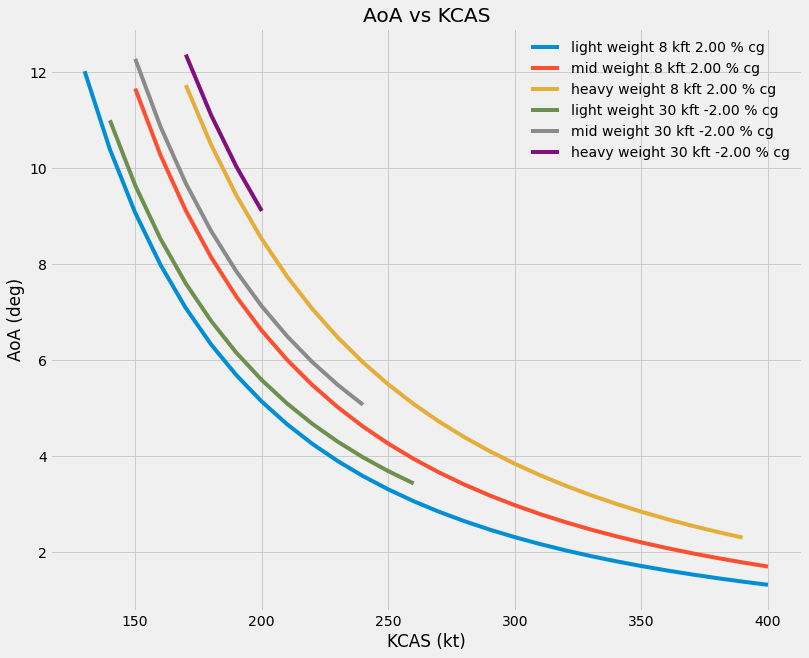

In [4]:
# Originally developed by JSBSim Team
# Modified by Guilherme A. L. da Silva - aerothermalsolutions.co
# Calculation required by aircraft icing enginering

import jsbsim
from IPython.core.display import display, HTML
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

# function to change CG in aircraft xml
# change the directory to the aircraft to be studied
def changeCG(cgPos,readOnly):
    tree = ET.parse('../../aircraft/global5000/global5000.xml')
    root = tree.getroot()

    for x in root.findall('mass_balance/location'):
        cg = x.find('x').text
        if not readOnly:
             x.find('x').text=str(cgPos)
             tree.write('../../aircraft/global5000/global5000.xml')
    return cg

#Fuel Max for Global5000
fuelmax=8097.63

#prepare subplots to overlay plots
fig, ax = plt.subplots(figsize=(10,8))

#Define here the payloads to be studied
payload=[1500,15172/2,15172]
#Define here the mass of fuel
fuel=[1000,fuelmax/2,fuelmax]
#three cases for weight
weight=["light","mid","heavy"]

#get the original CG from aircraft xml
cgOrig=float(changeCG(0,True))

#vary CG in the study
cgPos=[cgOrig*1.02,cgOrig*0.98]

#vary altitude
h_ft=[8000,30000]

#run the simulation varying CG, altitude, speed and total weight
for j in range(2):
    cg=changeCG(cgPos[j],False)
    fdm = jsbsim.FGFDMExec('../../') 
    fdm.load_model('global5000')
    # Set engines running
    fdm['propulsion/engine[0]/set-running'] = 1
    fdm['propulsion/engine[1]/set-running'] = 1
    for i in range(3):
        results = []
        for speed in range(90, 460, 10):
            fdm['ic/h-sl-ft'] = h_ft[j]
            fdm['ic/vc-kts'] = speed
            fdm['ic/gamma-deg'] = 0
            fdm['propulsion/tank[0]/contents-lbs'] = fuel[i]
            fdm['propulsion/tank[1]/contents-lbs'] = fuel[i]
            fdm['propulsion/tank[2]/contents-lbs'] = fuel[i]
            fdm['inertia/pointmass-weight-lbs[0]'] = payload[i]
            fdm['inertia/mass_balance-positionx-in'] = cgPos[j]

            fdm.run_ic() # Initialize the aircraft with initial conditions
            fdm.run()

            # Trim
            try:
                fdm['simulation/do_simple_trim'] = 1
                results.append((fdm['velocities/vc-kts'], fdm['aero/alpha-deg']))
            except RuntimeError as e:
                # The trim cannot succeed. Just make sure that the raised exception
                # is due to the trim failure otherwise rethrow.
                if e.args[0] != 'Trim Failed':
                    raise
        
        print("-----------------------------------------")
        print("Altitude {} - Weight {} - CG {}".format(h_ft[j],weight[i],cgPos[j]))
        print("-----------------------------------------")
        for result in results:
            print(result[0], result[1])

        speed, alpha = zip(*results)
        plt.plot(speed, alpha,label="{0} weight {1:.0f} kft {2:.2f} % cg".format(weight[i],h_ft[j]/1000,(float(cgPos[j])/float(cgOrig)-1)*100))

#plot final results
plt.legend(frameon=False)
plt.xlabel('KCAS (kt)')
plt.ylabel('AoA (deg)')
plt.title('AoA vs KCAS')

plt.show()

#restore original CG for the aircraft xml
cgx=changeCG(str(cgOrig),False)